In [1]:
import pickle
import os
import pandas as pd
from glob import glob
from tqdm import tqdm
import geopandas as gpd
import numpy as np

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_22733/893512367.py:6: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling 

In [2]:
road_network = gpd.read_file("/data_nas/GoogleSV/metadata/China/HongKong/edges.shp")
data = pd.read_csv('/data2/cehou/LLM_safety/img_text_data/mapping/export_files/age_30_female/age_30_female.csv')
metadata = pd.read_pickle("/data_nas/GoogleSV/metadata/China/HongKong/download_pano_2024-08-17 13:11:09.125553_23512.p")
data = data.drop_duplicates('panoid')

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 选择特征
features = data[['lat', 'lon']]
# 创建并拟合 KMeans 模型
kmeans = KMeans(n_clusters=50, random_state=42)
data['cluster'] = kmeans.fit_predict(features)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
from scipy.spatial import cKDTree
for i in tqdm(range(50)):
    sampled_data = data[data['cluster'] == i]
    k = 5
    # 获取已知 Score 的点
    known_points = sampled_data[sampled_data['Score'].notna()]
    unknown_points = sampled_data[sampled_data['Score'].isna()]

    # 构建 KDTree
    tree = cKDTree(known_points[['lon', 'lat']])

    # 查找每个未知点的最近的五个已知点
    distances, indices = tree.query(unknown_points[['lon', 'lat']], k=k)

    # 计算反距离权重
    weights = 1 / distances
    weights /= weights.sum(axis=1)[:, None]

    interpolated_score_matrix = np.zeros(indices.shape)
    for i in range(indices.shape[0]):
        for j in range(indices.shape[1]):
            interpolated_score_matrix[i, j] = known_points.iloc[indices[i, j]]['Score']

    # 计算加权平均值
    interpolated_scores = (weights * interpolated_score_matrix).sum(axis=1)

    # 将插值结果赋值给未知点
    # sampled_data.loc[sampled_data['Score'].isna(), 'Score'] = interpolated_scores
    data.loc[unknown_points.index, 'Score'] = interpolated_scores

 82%|████████▏ | 41/50 [01:57<00:21,  2.42s/it]/tmp/ipykernel_156038/600841116.py:16: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1 / distances
/tmp/ipykernel_156038/600841116.py:17: RuntimeWarning: invalid value encountered in true_divide
  weights /= weights.sum(axis=1)[:, None]
100%|██████████| 50/50 [02:16<00:00,  2.72s/it]


In [29]:
road_network = road_network.reset_index().rename(columns={'index': 'id'})

In [36]:
merged_data = data.merge(metadata[['panoid','id']], on='panoid', how='left')
merged_data = merged_data.drop(columns=['geometry'])
merged_data = merged_data.merge(road_network[['id','geometry']], on='id', how='left')

In [39]:
merged_data_gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')
merged_data_gdf.set_crs(epsg=4326, inplace=True)
merged_data_gdf.to_file('/data2/cehou/LLM_safety/img_text_data/mapping/interpolated_files/age_30_female.shp')

In [42]:
merged_data_gdf.to_file('/data2/cehou/LLM_safety/img_text_data/mapping/interpolated_files/age_30_female.shp')

<Axes: >

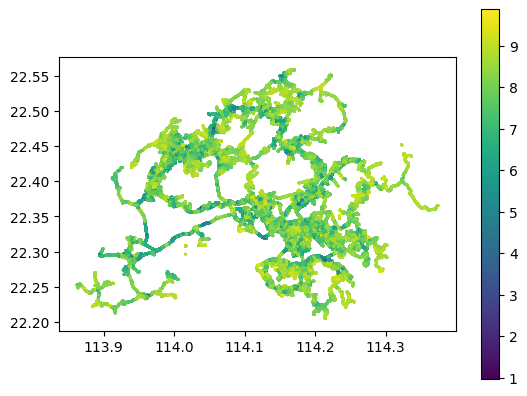

In [21]:
gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon, data.lat)).plot(column='Score', legend=True, markersize=1)